# Notebook to explore the decorrelating effect of on-site rotations of </br> <100 >-oriented dumbbells in an FCC solid

In [1]:
import numpy as np

# from onsager.crystal import Crystal
# from onsager.crystalStars import zeroclean
from onsager.OnsagerCalc import dumbbellMediated
from onsager.crystal import DB_disp, DB_disp4 #, pureDBContainer, mixedDBContainer
from onsager.DB_structs import dumbbell, SdPair, jump, connector

import time
import pickle
# from scipy.constants import physical_constants
# kB = physical_constants['Boltzmann constant in eV/K'][0]
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
# from scipy.linalg import pinv2
# from onsager.crystalStars import zeroclean

from tqdm import tqdm

In [2]:
# with open('NiFe_NiCr_08_31_2020.pkl','rb') as fl:
with open('NiFe_NiCr_Onsg.pkl','rb') as fl:
    onsagercalculator = pickle.load(fl)

pdbcontainer_Ni = onsagercalculator.pdbcontainer
mdbcontainer_Ni = onsagercalculator.mdbcontainer
print(onsagercalculator.crys)

#Lattice:
  a1 = [0.    0.176 0.176]
  a2 = [0.176 0.    0.176]
  a3 = [0.176 0.176 0.   ]
#Basis:
  (Ni) 0.0 = [0. 0. 0.]


In [3]:
# First, let us weed out jumps to and from "origin" states (see our paper)
# "Origin" states are where the solute and pure dumbbell are at the same site - which is unphysical.
# There should be two kinds - one to and from origin states and the second on-site rotation in an origin state

# For a dumbbell, the (i, or) indices (iorInd) correspond to (basis site, orientation vector) pairs.
# The corresponding values can be found at onsagercalculator.pdbcontainer.iorlist[iorInd]

# The basis index of the solute corresponds to which unit cell site type it occupies.

# The quantity "c1" indicates whether the atom at the head (c1 = 1) or the tail (c1 = -1) of the
# orientation vector is executing the jump

# The quantity "c2" indicates whether the jumping atom ends up at the head (c2 = 1) or the 
# tail (c2 = -1) of the final orientation vector.

origin_index = []
for idx, jlist in enumerate(onsagercalculator.jnet1):
    if jlist[0].state2.is_zero(onsagercalculator.pdbcontainer):
        print("Origin state omega1 jump type index : {}".format(idx))
        print(jlist[0])
        origin_index.append(idx)
        print()
        continue
    if jlist[0].state1.is_zero(onsagercalculator.pdbcontainer):
        print("Origin state omega1 jump type index : {}".format(idx))
        print(jlist[0])
        origin_index.append(idx)
        print()
        continue

print(origin_index)

Origin state omega1 jump type index : 0
Jump object:
Initial state:
	Solute loctation:basis index = 0, lattice vector = [0 0 0]
	dumbbell : (i, or) index = 0, lattice vector = [0 0 0]
Final state:
	Solute loctation :basis index = 0, lattice vector = [0 0 0]
	dumbbell : (i, or) index = 1, lattice vector = [ 0  1 -1]
Jumping from c1 = 1 to c2 = -1

Origin state omega1 jump type index : 13
Jump object:
Initial state:
	Solute loctation:basis index = 0, lattice vector = [0 0 0]
	dumbbell : (i, or) index = 0, lattice vector = [0 0 0]
Final state:
	Solute loctation :basis index = 0, lattice vector = [0 0 0]
	dumbbell : (i, or) index = 1, lattice vector = [0 0 0]
Jumping from c1 = 1 to c2 = 1

[0, 13]


In [4]:
## In order to make this a bit less tedious, let's first filter out the rotation jumps
rot_index = []

# iterate through the omega1 jump types (which are grouped by symmetry)
for i, jlist in enumerate(onsagercalculator.jnet1):
    jmp = jlist[0] # Get a representative jump
    
    # check the dumbbell displacement during the jump
    dx = DB_disp(pdbcontainer_Ni, jmp.state1, jmp.state2) # the disp function is in states.py
    
    db1 = jmp.state1.db
    db2 = jmp.state2.db
    
    i1, R1 = pdbcontainer_Ni.iorlist[db1.iorind][0], db1.R
    i2, R2 = pdbcontainer_Ni.iorlist[db2.iorind][0], db2.R
    
    x1 = pdbcontainer_Ni.crys.pos2cart(R1, (0, i1))
    x2 = pdbcontainer_Ni.crys.pos2cart(R2, (0, i2))
    
    assert np.allclose(x2-x1, dx)
    
    # if the displacement is zero, then we have a rotation
    # if the rotation is of an origin state, ignore it, since we have identified it before.
    if np.allclose(dx, 0.) and not i in origin_index:
        rot_index.append(i)
print(rot_index)

[14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]


In [6]:
# Now we'll play around with the relative rates of rotation and roto-translation jumps.

# 1.  First get the rates and thermodynamic data

# 1a. Energies and pre-factors
rot = 2.0
trans = 0.0

predb0, enedb0 = np.ones(1), np.array([0])

preS, eneS = np.ones(1), np.zeros(1)

# set interaction energies to zero
preSdb, eneSdb = np.ones(onsagercalculator.thermo.mixedstartindex), \
                 np.array([0., 0., 0.])

predb2, enedb2 = np.ones(1), np.array([0])

# The first type is roto-trans, the second is onsite rot.
preT0, eneT0 = np.ones(len(onsagercalculator.vkinetic.starset.jnet0)), np.array([trans, rot])


# Omega2 TS energies
Nj2 = len(onsagercalculator.jnet2)
preT2, eneT2 = np.ones(Nj2), np.array([trans, rot])

# Omega43 TS energies
preT43, eneT43 = np.ones(len(onsagercalculator.jnet43)), np.array([trans])

# Omega1 TS energies
preT1 = np.ones(len(onsagercalculator.jnet1))

eneT1 = np.zeros(len(onsagercalculator.jnet1))
# from 14 to 25, we have on-site rotations
# 0 and 13 are origin state jumps
eneT1[1:12] = trans
eneT1[14:] = rot

kT = 1

# We'll vary the barriers by -10 to 10 energy units of the rotation rates
# to see what happens when rotations become very probable to very less probable.
inc = np.linspace(-10,10,51)

diff_aa_Ni2 = np.zeros(len(inc))
diff_bb_Ni2 = np.zeros(len(inc))
diff_ab_Ni2 = np.zeros(len(inc))
diff_bb_non_loc_Ni = np.zeros(len(inc))

omega2_RT = np.zeros(len(inc))
omega2_rot = np.zeros(len(inc))

for i in tqdm(range(len(inc)), position=0, leave=True, ncols=65):
    
    eneT2 = np.array([trans, rot + inc[i]])
    eneT0 = np.array([trans, rot + inc[i]])
    eneT1[14:] = trans + inc[i]
    

    bFdb0, bFdb2, bFS, bFSdb, bFT0, bFT1, bFT2, bFT3, bFT4 = \
        onsagercalculator.preene2betafree(kT, predb0, enedb0, preS, eneS, preSdb, eneSdb, predb2, enedb2,
                                               preT0, eneT0, preT2, eneT2, preT1, eneT1, preT43, eneT43)
    #     bFdicts[i] = [bFdb0, bFdb2, bFS, bFSdb, bFT0, bFT1, bFT2, bFT3, bFT4]
    # get the probabilities and other data from L_ij
    L0bb, (L_uc_aa,L_c_aa), (L_uc_bb,L_c_bb), (L_uc_ab,L_c_ab) =\
    onsagercalculator.L_ij(bFdb0, bFT0, bFdb2, bFT2, bFS, bFSdb, bFT1, bFT3, bFT4)

    L_aa = L_uc_aa + L_c_aa
    L_bb = L_uc_bb + L_c_bb
    L_ab = L_uc_ab + L_c_ab

    diff_aa_Ni2[i] = L_aa[0][0]
    diff_bb_Ni2[i] = L_bb[0][0]
    diff_ab_Ni2[i] = L_ab[0][0]
    diff_bb_non_loc_Ni[i] = L0bb[0][0]
    
    omegas = onsagercalculator.omegas
    
    omega2_RT[i] = omegas[2][0][0]
    omega2_rot[i] = omegas[2][0][1]

100%|████████████████████████████| 51/51 [01:00<00:00,  1.19s/it]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


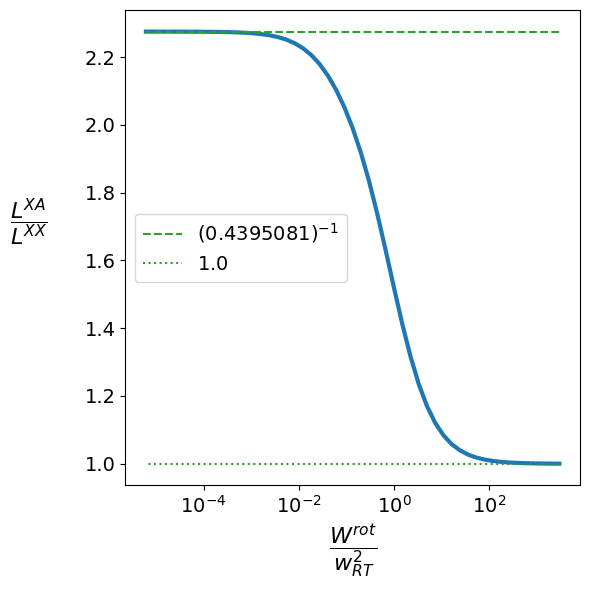

In [9]:
fig, ax1 = plt.subplots(1,1,figsize=(6,6))

ax1.semilogx(omega2_rot/omega2_RT, diff_ab_Ni2/diff_aa_Ni2, color="tab:blue", lw=3)
ax1.plot(omega2_rot/omega2_RT, np.ones_like(diff_aa_Ni2)/0.4395081, ls="--", label=r'$(0.4395081)^{-1}$',
        color="tab:green")

ax1.plot(omega2_rot/omega2_RT, np.ones_like(diff_aa_Ni2), ls=":", label=r'$1.0$',
        color="tab:green")

ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(axis='both', which='minor', labelsize=14)
ax1.set_xlabel(r'$\dfrac{W^{rot}}{w^2_{RT}}$', fontsize=16)
ax1.set_ylabel(r'$\dfrac{L^{XA}}{L^{XX}}$', fontsize=16, rotation=0, labelpad=40)

ax1.legend(fontsize=14)

plt.tight_layout()
plt.savefig("Drag_Tracer_FCC_rot_vs_trans.pdf", bbox_inches="tight", format="pdf")
plt.savefig("Drag_Tracer_FCC_rot_vs_trans.eps", bbox_inches="tight", format="eps")

In [10]:
np.min(diff_ab_Ni2/diff_aa_Ni2) # this value cannot be less that one.

1.000335357029533